In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Cargar el dataset
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/My Drive/MODELOS MONOGRAFIA/otrasinfeccionesMonografia.csv", sep=";")

# Mostrar las primeras filas del dataset para analizar su estructura
data.head()

Mounted at /content/drive


,fecha,semana,tipo,varones,mujeres,total
0,7/1/2019,1,EDA,486,527,1013
1,7/1/2019,1,IRAsinNeumo,1176,1292,2468
2,7/1/2019,1,neumonia,30,36,66
3,14/1/2019,2,EDA,585,627,1212
4,14/1/2019,2,IRAsinNeumo,1789,1963,3752


In [ ]:
data_ira_mujeres = data[data['tipo'] == 'IRAsinNeumo'][['fecha', 'mujeres']]
data_ira_mujeres['fecha'] = pd.to_datetime(data_ira_mujeres['fecha'], dayfirst=True)
data_ira_mujeres = data_ira_mujeres.sort_values(by='fecha')
data_ira_mujeres.set_index('fecha', inplace=True)

# Prueba de Dickey-Fuller para verificar estacionaridad
result_ira_mujeres = adfuller(data_ira_mujeres['mujeres'])
print('Prueba de Dickey-Fuller para IRAsinNeumo - Mujeres:')
print(f'Estadístico de prueba: {result_ira_mujeres[0]:.4f}')
print(f'P-valor: {result_ira_mujeres[1]:.4f}')
for key, value in result_ira_mujeres[4].items():
    print(f'Valor Crítico {key}: {value:.4f}')

Prueba de Dickey-Fuller para IRAsinNeumo - Mujeres:
Estadístico de prueba: -2.8124
P-valor: 0.0565
Valor Crítico 1%: -3.4531
Valor Crítico 5%: -2.8716
Valor Crítico 10%: -2.5721


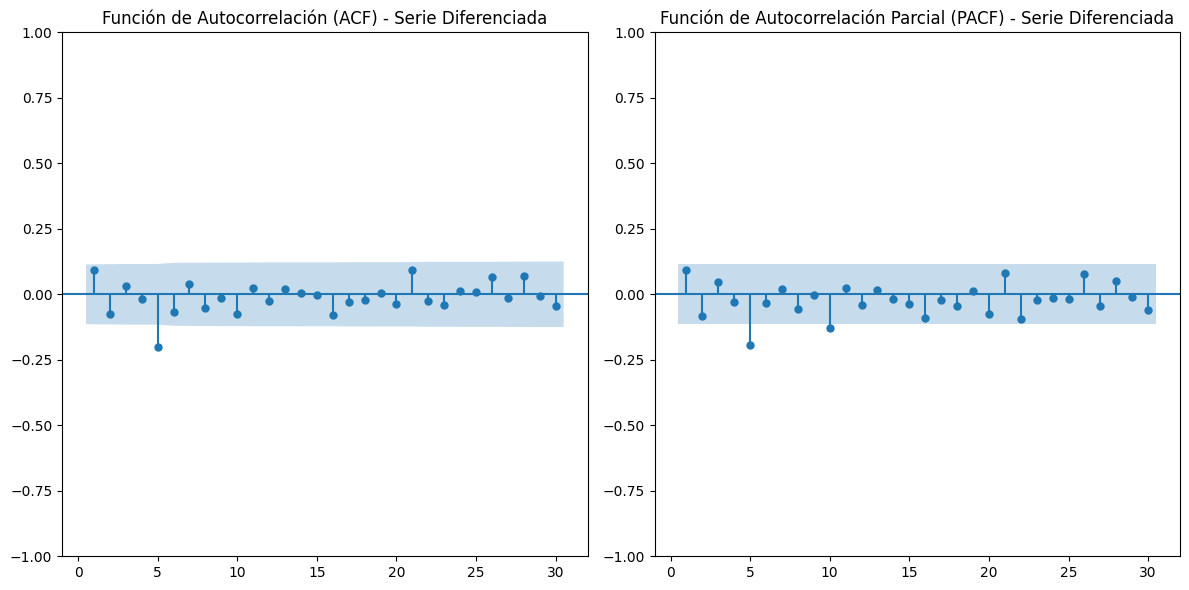

In [ ]:

# Diferenciar la serie para hacerla estacionaria
data_ira_mujeres_diff = data_ira_mujeres['mujeres'].diff().dropna()

# Graficar ACF y PACF de la serie diferenciada
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(data_ira_mujeres_diff, lags=30, zero=False, ax=plt.gca())
plt.title("Función de Autocorrelación (ACF) - Serie Diferenciada")

plt.subplot(1, 2, 2)
plot_pacf(data_ira_mujeres_diff, lags=30, zero=False, ax=plt.gca())
plt.title("Función de Autocorrelación Parcial (PACF) - Serie Diferenciada")

plt.tight_layout()
plt.show()

# ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                mujeres   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1836.254
Date:                Sat, 30 Nov 2024   AIC                           3678.509
Time:                        16:01:43   BIC                           3689.073
Sample:                    01-07-2019   HQIC                          3682.760
                         - 10-23-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2010      0.518     -0.388      0.698      -1.217       0.815
ma.L1          0.3219      0.503      0.640      0.522      -0.663       1.307
sigma2      1.409e+05   7567.373     18.617      0.0

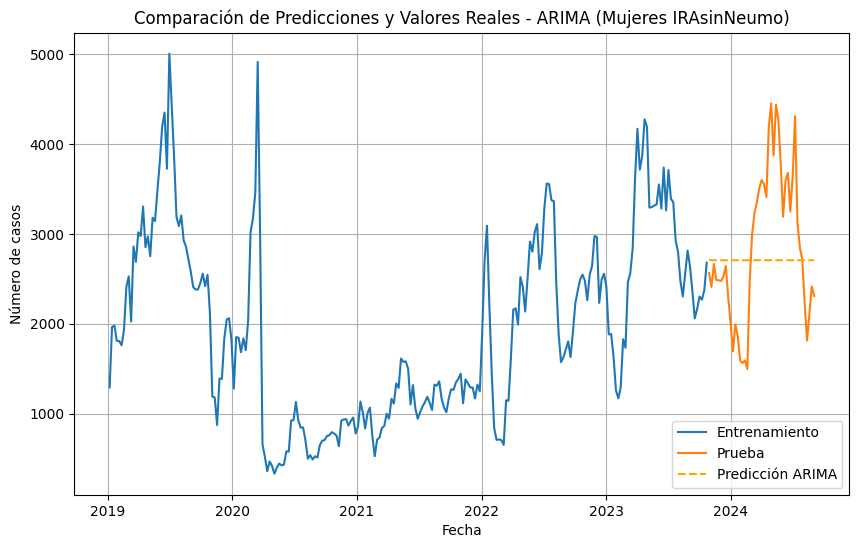

MAE: 711.50
RMSE: 852.19
MAPE: 26.51%
sMAPE: 25.40%


In [ ]:


# Dividir la serie en entrenamiento y prueba (85% entrenamiento, 15% prueba)
train_size_ira_mujeres = int(len(data_ira_mujeres) * 0.85)
train_ira_mujeres, test_ira_mujeres = data_ira_mujeres['mujeres'][:train_size_ira_mujeres], data_ira_mujeres['mujeres'][train_size_ira_mujeres:]

# Entrenar el modelo ARIMA
model_arima_ira_mujeres = ARIMA(train_ira_mujeres, order=(1, 1, 1))
arima_result_ira_mujeres = model_arima_ira_mujeres.fit()

# Mostrar el resumen del modelo
print(arima_result_ira_mujeres.summary())

# Generar predicciones en el conjunto de prueba
predictions_arima_ira_mujeres = arima_result_ira_mujeres.forecast(steps=len(test_ira_mujeres))

# Graficar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(train_ira_mujeres.index, train_ira_mujeres, label="Entrenamiento")
plt.plot(test_ira_mujeres.index, test_ira_mujeres, label="Prueba")
plt.plot(test_ira_mujeres.index, predictions_arima_ira_mujeres, color='orange', linestyle='--', label="Predicción ARIMA")
plt.title("Comparación de Predicciones y Valores Reales - ARIMA (Mujeres IRAsinNeumo)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

# Calcular métricas de evaluación: MAE, RMSE, MAPE y sMAPE
mae_ira_mujeres = mean_absolute_error(test_ira_mujeres, predictions_arima_ira_mujeres)
rmse_ira_mujeres = np.sqrt(mean_squared_error(test_ira_mujeres, predictions_arima_ira_mujeres))
mape_ira_mujeres = mean_absolute_percentage_error(test_ira_mujeres, predictions_arima_ira_mujeres) * 100  # Convertir a porcentaje
smape_ira_mujeres = 100 * np.mean(2 * np.abs(test_ira_mujeres - predictions_arima_ira_mujeres) / (np.abs(test_ira_mujeres) + np.abs(predictions_arima_ira_mujeres)))

# Imprimir métricas
print(f'MAE: {mae_ira_mujeres:.2f}')
print(f'RMSE: {rmse_ira_mujeres:.2f}')
print(f'MAPE: {mape_ira_mujeres:.2f}%')
print(f'sMAPE: {smape_ira_mujeres:.2f}%')

# SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                            mujeres   No. Observations:                  251
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1485.818
Date:                            Sat, 30 Nov 2024   AIC                           2981.635
Time:                                    16:02:11   BIC                           2998.076
Sample:                                01-07-2019   HQIC                          2988.290
                                     - 10-23-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0369      0.494      0.075      0.940      -0.932       1.005
ma.L1          0.1246      0.480   

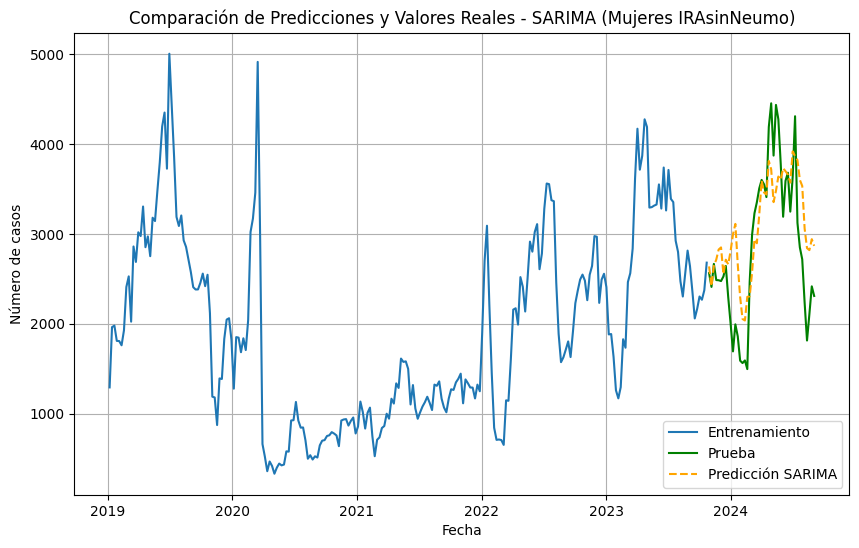

MAE: 461.45
RMSE: 565.81
MAPE: 19.36%
sMAPE: 16.97%


In [ ]:

# Configuración del modelo SARIMA: (p, d, q) x (P, D, Q, s)
# Usaremos los valores (1, 1, 1) para (p, d, q) y probaremos con estacionalidad (P=1, D=1, Q=1, s=52)
model_sarima_ira_mujeres = SARIMAX(train_ira_mujeres, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_result_ira_mujeres = model_sarima_ira_mujeres.fit()

# Mostrar el resumen del modelo SARIMA
print(sarima_result_ira_mujeres.summary())

# Generar predicciones en el conjunto de prueba
predictions_sarima_ira_mujeres = sarima_result_ira_mujeres.forecast(steps=len(test_ira_mujeres))

# Graficar predicciones SARIMA vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(train_ira_mujeres.index, train_ira_mujeres, label="Entrenamiento")
plt.plot(test_ira_mujeres.index, test_ira_mujeres, label="Prueba", color='green')
plt.plot(test_ira_mujeres.index, predictions_sarima_ira_mujeres, color='orange', linestyle='--', label="Predicción SARIMA")
plt.title("Comparación de Predicciones y Valores Reales - SARIMA (Mujeres IRAsinNeumo)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

# Calcular métricas de evaluación: MAE, RMSE, MAPE y sMAPE
mae_sarima_ira_mujeres = mean_absolute_error(test_ira_mujeres, predictions_sarima_ira_mujeres)
rmse_sarima_ira_mujeres = np.sqrt(mean_squared_error(test_ira_mujeres, predictions_sarima_ira_mujeres))
mape_sarima_ira_mujeres = mean_absolute_percentage_error(test_ira_mujeres, predictions_sarima_ira_mujeres) * 100  # Convertir a porcentaje
smape_sarima_ira_mujeres = 100 * np.mean(2 * np.abs(test_ira_mujeres - predictions_sarima_ira_mujeres) / (np.abs(test_ira_mujeres) + np.abs(predictions_sarima_ira_mujeres)))

# Imprimir métricas
print(f'MAE: {mae_sarima_ira_mujeres:.2f}')
print(f'RMSE: {rmse_sarima_ira_mujeres:.2f}')
print(f'MAPE: {mape_sarima_ira_mujeres:.2f}%')
print(f'sMAPE: {smape_sarima_ira_mujeres:.2f}%')

In [ ]:
# Crear DataFrame comparativo de los valores reales y predichos para SARIMA
comparison_df_ira_mujeres_sarima = pd.DataFrame({
    'Fecha': test_ira_mujeres.index,
    'Reales': test_ira_mujeres,
    'Predicciones SARIMA': round(predictions_sarima_ira_mujeres)
})

# Mostrar el DataFrame comparativo
print(comparison_df_ira_mujeres_sarima)

                Fecha  Reales  Predicciones SARIMA
2023-10-30 2023-10-30    2564               2639.0
2023-11-06 2023-11-06    2411               2420.0
2023-11-13 2023-11-13    2667               2643.0
2023-11-20 2023-11-20    2487               2715.0
2023-11-27 2023-11-27    2485               2826.0
2023-12-04 2023-12-04    2476               2851.0
2023-12-11 2023-12-11    2527               2552.0
2023-12-18 2023-12-18    2644               2714.0
2023-12-25 2023-12-25    2299               2663.0
2024-01-01 2024-01-01    2005               2809.0
2024-01-08 2024-01-08    1693               2994.0
2024-01-15 2024-01-15    1994               3112.0
2024-01-22 2024-01-22    1861               2662.0
2024-01-29 2024-01-29    1590               2299.0
2024-02-05 2024-02-05    1563               2054.0
2024-02-12 2024-02-12    1592               2037.0
2024-02-19 2024-02-19    1496               2300.0
2024-02-26 2024-02-26    2469               2306.0
2024-03-04 2024-03-04    2991  

In [ ]:
# prompt: realiza 8 predicciones a futuro

# Generar 8 predicciones a futuro con el modelo SARIMA
future_steps = 8
future_predictions_sarima_ira_mujeres = sarima_result_ira_mujeres.get_forecast(steps=future_steps)

# Obtener las predicciones y los intervalos de confianza
future_predictions = future_predictions_sarima_ira_mujeres.predicted_mean
confidence_intervals = future_predictions_sarima_ira_mujeres.conf_int()

# Imprimir las predicciones a futuro
print("Predicciones a futuro (SARIMA):")
print(future_predictions)

# Crear un DataFrame para las predicciones a futuro
future_dates = pd.date_range(start=data_ira_mujeres.index[-1] + pd.DateOffset(1), periods=future_steps, freq='W')  # Ajusta la frecuencia según sea necesario
future_df = pd.DataFrame({
    'Fecha': future_dates,
    'Predicciones SARIMA': future_predictions.round()
})

# Imprimir el DataFrame de predicciones a futuro
future_df

Predicciones a futuro (SARIMA):
2023-10-30    2638.856899
2023-11-06    2420.484522
2023-11-13    2643.411676
2023-11-20    2714.830719
2023-11-27    2826.456953
2023-12-04    2850.665831
2023-12-11    2551.877812
2023-12-18    2713.651021
Freq: W-MON, Name: predicted_mean, dtype: float64


,Fecha,Predicciones SARIMA
2023-10-30,2024-09-08,2639.0
2023-11-06,2024-09-15,2420.0
2023-11-13,2024-09-22,2643.0
2023-11-20,2024-09-29,2715.0
2023-11-27,2024-10-06,2826.0
2023-12-04,2024-10-13,2851.0
2023-12-11,2024-10-20,2552.0
2023-12-18,2024-10-27,2714.0


In [ ]:
# prompt: estos son los valores reales a futuro, comparalos con los predichos y evalualos:
# 2353
# 2473
# 1967
# 2042
# 1735
# 1814
# 1876
# 1931
# 1720

import pandas as pd
import numpy as np

# Valores reales a futuro
real_values = [2353, 2473, 1967, 2042, 1735, 1814, 1876, 1931]

# Obtener las predicciones del modelo desde el DataFrame future_df
# Asumiendo que 'future_df' existe en el contexto de ejecución del código anterior.
# Ajusta esto según el nombre real de tu DataFrame y la columna de predicciones

# Asegúrate de que future_df esté definido
try:
    future_predictions = future_df['Predicciones SARIMA'].values
except NameError:
    print("Error: 'future_df' no está definida. Asegúrate de que el código que genera el DataFrame future_df se haya ejecutado correctamente.")
    future_predictions = [0] * len(real_values) #valor por defecto para prevenir error

#Evaluar solo los 8 primeros valores predichos, descartar el noveno
future_predictions = future_predictions[:8]


# Calcular métricas de evaluación
mae = np.mean(np.abs(real_values[:8] - future_predictions))
rmse = np.sqrt(np.mean((real_values[:8] - future_predictions)**2))
mape = np.mean(np.abs((real_values[:8] - future_predictions) / real_values[:8])) * 100
smape = 100 * np.mean(2 * np.abs(real_values[:8] - future_predictions) / (np.abs(real_values[:8]) + np.abs(future_predictions)))


# Crear un DataFrame para comparar
comparison_df = pd.DataFrame({
    'Real': real_values[:8],
    'Predicción': future_predictions
})

print(comparison_df)
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'sMAPE: {smape:.2f}%')

   Real  Predicción
0  2353      2639.0
1  2473      2420.0
2  1967      2643.0
3  2042      2715.0
4  1735      2826.0
5  1814      2851.0
6  1876      2552.0
7  1931      2714.0
MAE: 659.38
RMSE: 735.72
MAPE: 34.78%
sMAPE: 28.47%


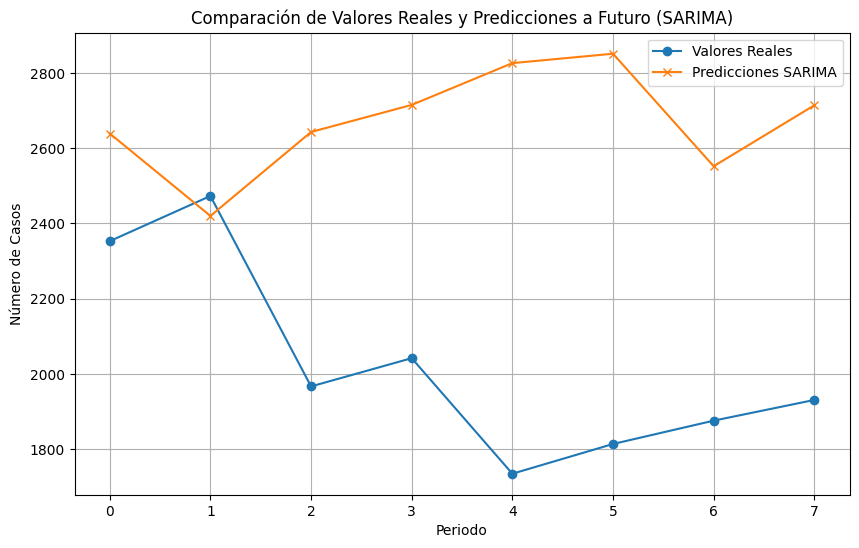

In [ ]:
# prompt: grafica la comparacion

# Gráfica de comparación entre valores reales y predicciones a futuro
plt.figure(figsize=(10, 6))
plt.plot(range(len(real_values[:8])), real_values[:8], label="Valores Reales", marker='o')
plt.plot(range(len(future_predictions)), future_predictions, label="Predicciones SARIMA", marker='x')
plt.title("Comparación de Valores Reales y Predicciones a Futuro (SARIMA)")
plt.xlabel("Periodo")
plt.ylabel("Número de Casos")
plt.legend()
plt.grid(True)
plt.show()